In [1]:
# pip installs

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset

from tokenizers import Tokenizer, models, pre_tokenizers, trainers
from transformers import BertTokenizerFast

from sklearn.model_selection import train_test_split
import statistics
from tqdm import tqdm

from zipfile import ZipFile

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


# Data preprocessing

here we load the data and process two lists: 'sentences_with_nikud', 'sentences_without_nikud'

In [3]:
def load_data(data_path):
    """Loads the data from the given path and returns a list of sentences."""
    # Load the data
    df = pd.read_csv(data_path)

    # Prepare a list to store sentences
    sentences = []
    current_sentence = []

    # Go through each row in the dataframe
    for i, row in df.iterrows():
        # Check if the row is a sentence start
        if str(row['ID (word index)']).startswith("# text"):
            # If there is a sentence in progress, add it to the list
            if current_sentence:
                sentences.append(" ".join(current_sentence).replace(" _", ""))
                current_sentence = []
        else:
            # If the row is a word, add it to the current sentence
            word = str(row['LEMMA'])
            if word != "nan":
                current_sentence.append(word)

    # Add the last sentence if necessary
    if current_sentence:
        sentences.append(" ".join(current_sentence).replace(" _", ""))

    return sentences



def remove_nikud(sentence):
    """Removes the nikud from the given sentence."""
    nikud = re.compile(r'[\u05B0-\u05C2]') # Nikud unicode range (https://en.wikipedia.org/wiki/Unicode_and_HTML_for_the_Hebrew_alphabet)
    return nikud.sub("", sentence)

def split_sentences_to_with_without_nikud(sentences):
    # Create lists for sentences with and without nikud
    sentences_with_nikud = [sentence for sentence in sentences if re.search(r'[\u05B0-\u05C2]', sentence)]
    sentences_without_nikud = [remove_nikud(sentence) for sentence in sentences_with_nikud]
    return sentences_with_nikud, sentences_without_nikud

# Load the data
sentences = load_data(data_path='data/morphologicaltagging_v_2_1.csv')

# Split the sentences into those with and without nikud
sentences_with_nikud, sentences_without_nikud = split_sentences_to_with_without_nikud(sentences)

print(f"Number of sentences with nikud: {len(sentences_with_nikud)}")
print(f"Number of sentences without nikud: {len(sentences_without_nikud)}")


Number of sentences with nikud: 1919
Number of sentences without nikud: 1919


In [13]:
print(sentences_with_nikud[0])
print(sentences_without_nikud[0])

נִתַּן נִכְנַס לְ מַעֲרֶכֶת הַ הִזְדַּהוּת בְּ מִסְפָּר אֶמְצָעִי שׁוֹנֶה .
נתן נכנס ל מערכת ה הזדהות ב מספר אמצעי שונה .


create df and split to train, val and test

In [4]:
# create a dataframe with two columns: "with_nikud" and "without_nikud"
data_df = pd.DataFrame({'with_nikud': sentences_with_nikud, 'without_nikud': sentences_without_nikud})
# split the data into train val and test
train_df, test_df = train_test_split(data_df, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f"Number of train sentences: {len(train_df)}")
print(f"Number of val sentences: {len(val_df)}")
print(f"Number of test sentences: {len(test_df)}")

Number of train sentences: 1554
Number of val sentences: 173
Number of test sentences: 192


In [5]:
# split and print first sentence with and without nikud
print(f"First sentence with nikud: {train_df['with_nikud'].iloc[0].split()}")
print(f"First sentence without nikud: {train_df['without_nikud'].iloc[0].split()}")

all_words_with_nikud = [word for sentence in train_df['with_nikud'] for word in sentence.split()]
all_words_without_nikud = [word for sentence in train_df['without_nikud'] for word in sentence.split()]
all_words_with_nikud = list(set(all_words_with_nikud))
all_words_without_nikud = list(set(all_words_without_nikud))
print(f"Number of words with nikud: {len(all_words_with_nikud)}")
print(f"Number of words without nikud: {len(all_words_without_nikud)}")

# create a list of all unique words
all_words = list(set(all_words_with_nikud + all_words_without_nikud))
print(f"Number of unique words: {len(all_words)}")

# create a dictionary that maps each word to a unique index
word_to_index = {word: i for i, word in enumerate(all_words)}
index_to_word = {i: word for i, word in enumerate(all_words)}

First sentence with nikud: ['_', '(', 'א1', ')', 'לֹא', 'נִתַּן', 'הֶתֵּר', 'לְפִי', 'סְעִיף', 'זֶה', 'אֶלָּא', 'לְ', 'עוֹבֵד', 'מַעֲרֶכֶת', 'הַ', 'בִּטָּחוֹן', 'שֶׁ', 'הָעֳסַק', 'בְּ', 'תַּפְקִיד', 'מְסֻוָּג', 'וְ', 'נֶחְשַׂף', 'אוֹ', 'עָשׂוּי', 'נֶחְשַׂף', 'לְ', 'מֵידָע', 'בִּטְחוֹנִי', 'רָגִישׁ', 'בְּ', 'מִסְגֶּרֶת', 'הַ', 'הַעֲסָקָה', 'שֶׁל', 'הוּא', ',', 'וְ', 'לְאַחַר', 'שֶׁ', 'נִמְסַר', 'לְ', 'הוֹדָעָה', 'כְּ', 'הַ', 'אָמוּר', 'בְּ', 'סְעִיף', 'קָטָן', '(', 'בְּ', '1', ')', '.']
First sentence without nikud: ['_', '(', 'א1', ')', 'לא', 'נתן', 'התר', 'לפי', 'סעיף', 'זה', 'אלא', 'ל', 'עובד', 'מערכת', 'ה', 'בטחון', 'ש', 'העסק', 'ב', 'תפקיד', 'מסוג', 'ו', 'נחשף', 'או', 'עשוי', 'נחשף', 'ל', 'מידע', 'בטחוני', 'רגיש', 'ב', 'מסגרת', 'ה', 'העסקה', 'של', 'הוא', ',', 'ו', 'לאחר', 'ש', 'נמסר', 'ל', 'הודעה', 'כ', 'ה', 'אמור', 'ב', 'סעיף', 'קטן', '(', 'ב', '1', ')', '.']
Number of words with nikud: 3299
Number of words without nikud: 3041
Number of unique words: 5854


In [6]:
# find the sentence with the most words
max_sentence_len = 0
for sentence in sentences_with_nikud:
    if len(sentence.split()) > max_sentence_len:
        max_sentence_len = len(sentence.split())

# get vocab (make sure to add hebrew letters, with and without nikud)
vocab = {"words": all_words, "word_to_index": word_to_index, "index_to_word": index_to_word}

# print stats
print("Max sentence length: ", max_sentence_len)
print(vocab)


Max sentence length:  334
{'words': ['הֱיוֹת', 'תְּשׂוּאָה', 'מַשְׁכַּנְתָּה', 'מַדּוּעַ', 'מְמֻנֶּה', 'הגעה', 'מַטֶּה', 'כשר', 'תַּזְכִּיר', 'זנח', 'ברכה', 'חַלָּשׁ', 'אִי', 'הִתָּכְנוּת', 'נ"ל', 'הטבה', 'דֶּרֶךְ', 'מסוג', 'נכס', 'קובע', 'טָעַן', 'תְּמוּרָה', 'מעמיק', 'צנעה', 'אמצעי', '45', 'עָצְמָתִי', 'נִרְאֶה', 'שיח', 'אחוד', '50ב(א)', 'צַעַד', 'שקל', 'הִשְׁתַּנָּה', 'קַרְקַע', 'נערך', 'גָּז', 'כְּלָלוּת', 'מֻשְׂכָּל', 'החזק', 'הניע', '24', 'google', 'חֶלְקִי', 'עניני', 'נוֹכְחִי', 'לעמת', 'חָקַר', 'כֶּסֶף', '0.7', 'צליל', 'הֵבִיא', 'פֵּרָעוֹן', 'מחזוריות', 'יוֹם', 'נוֹסַד', 'לֶקֶט', 'יציבותיים', '־', 'רביעי', 'אפי', 'סְפָּאם', 'מִנָּה', '42', 'פָּגוּם', '1983', 'חקי', 'הרשאה', 'אִשּׁוּם', 'תִּכְנוּן', 'צמח', 'מחדש', '80', 'הִצְהִיר', 'ממשל', 'תַּאֲגִיד', 'בָּטַל', 'יִצֵּר', 'טוח', '13(5)', 'לירה', 'מַהֲלָךְ', 'מאוד', 'שָׁלַח', 'בדור', 'גָּרַס', 'מוֹנִיטָרִי', 'יפה', 'כְּשֶׁ', 'סֵלוּלָרִי', '14ה(ד)', '49', 'מדוע', 'קְהִלָּתִי', 'התשל״ז', 'יותר', 'דירקטוריון', '6(א)', 'צִלּוּם', 'פק

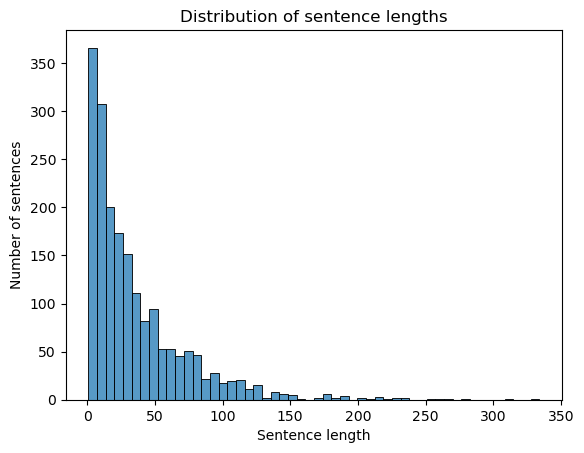

Mean sentence length: 36.09171443460136, Median sentence length: 23, Standard deviation of sentence length: 38.75121753450359


In [7]:
# some eda on the data
def get_sentence_len(sentence):
    return len(sentence.split())

# get the length of each sentence
sentence_lens = [get_sentence_len(sentence) for sentence in sentences_with_nikud]

# plot the distribution of sentence lengths
sns.histplot(sentence_lens)
plt.title("Distribution of sentence lengths")
plt.xlabel("Sentence length")
plt.ylabel("Number of sentences")
plt.show()

# get the mean sentence length
mean_sentence_len = statistics.mean(sentence_lens)
median_sentence_len = statistics.median(sentence_lens)
std_sentence_len = statistics.stdev(sentence_lens)
print("Mean sentence length: {}, Median sentence length: {}, Standard deviation of sentence length: {}".format(mean_sentence_len, median_sentence_len, std_sentence_len))

# create DataSet class

In [8]:
class HebrewNikudDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sentences_with_nikud = str(self.data.iloc[index]['with_nikud'])
        sentences_without_nikud = str(self.data.iloc[index]['without_nikud'])

        # Use the tokenizer to encode the sentences as input and output IDs
        inputs = self.tokenizer.encode_plus(
            sentences_without_nikud, # Sentence to encode.
            add_special_tokens=True, # Add '[CLS]' and '[SEP]'
            max_length=self.max_length, # Pad & truncate all sentences.
            padding='max_length', # Pad all sentences.
            truncation=True, # Truncate all sentences.
            return_tensors='pt', # Return pytorch tensors.
        )
        outputs = self.tokenizer.encode_plus(
            sentences_with_nikud,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )

        # Return the input and output IDs as well as the attention masks
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'output_ids': outputs['input_ids'].flatten(),
        }

In [9]:
from transformers import BertTokenizer
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
# add vocab to tokenizer
tokenizer.add_tokens(vocab["words"])
# Define the maximum sequence length
max_length = max_sentence_len # maybe better power of 2?


# Create datasets for training, validation, and testing
train_dataset = HebrewNikudDataset(train_df, tokenizer, max_length)
val_dataset = HebrewNikudDataset(val_df, tokenizer, max_length)
test_dataset = HebrewNikudDataset(test_df, tokenizer, max_length)

# performe EDAs on the data

In [10]:
# perform EDA on train_dataset, val_dataset, test_dataset

# check the number of samples in each set
print("Number of samples in train_dataset: ", len(train_dataset))
print("Number of samples in val_dataset: ", len(val_dataset))
print("Number of samples in test_dataset: ", len(test_dataset))

#TODO: deatail EDA on the datasets



Number of samples in train_dataset:  1554
Number of samples in val_dataset:  173
Number of samples in test_dataset:  192


# dataloader

In [11]:
# define the batch size
batch_size = 4

# Create dataloaders for training, validation, and testing
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# check the number of batches in each set
print("Number of batches in train_dataloader: ", len(train_dataloader))
print("Number of batches in val_dataloader: ", len(val_dataloader))
print("Number of batches in test_dataloader: ", len(test_dataloader))




Number of batches in train_dataloader:  389
Number of batches in val_dataloader:  44
Number of batches in test_dataloader:  48


# Define the two models (one with look-ahead, one without)

### train the two models

### Evaluate the models

In [12]:
class PunctuationPredictionModelWithLookahead(nn.Module):
    def __init__(self, num_words, num_punctuations, embedding_dim=256, num_heads=8, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(num_words, embedding_dim)
        self.transformer = nn.Transformer(embedding_dim, num_heads, num_layers)
        self.fc = nn.Linear(embedding_dim, num_punctuations)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = self.fc(x)
        return x


class PunctuationPredictionModelWithoutLookahead(nn.Module):
    def __init__(self, num_words, num_punctuations, embedding_dim=256, num_heads=8, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(num_words, embedding_dim)
        self.transformer = nn.Transformer(embedding_dim, num_heads, num_layers)
        self.fc = nn.Linear(embedding_dim, num_punctuations)

    def forward(self, x):
        x = self.embedding(x)
        mask = self._generate_future_mask(x.size(0)).to(x.device)
        x = self.transformer(x, src_mask=mask)
        x = self.fc(x)
        return x

    def _generate_future_mask(self, size):
        mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
    
# define the model
model = PunctuationPredictionModelWithoutLookahead(num_words=len(vocab["words"]), num_punctuations=3)



# Define the dual model class, it will be composed of two models.
#### whenever there is a disagreement between the two models, the model will add nikud using the lookahead model

## Evaluation of the dual model